# 1. Libraries and settings

In [1]:
import numpy as np
import pandas as pd

import lightgbm as lgb
import optuna.integration.lightgbm as lgbo

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error # 平均絶対誤差
#from sklearn.metrics import mean_squared_error # 平均二乗誤差
#from sklearn.metrics import mean_squared_log_error # 対数平均二乗誤差
from sklearn.metrics import r2_score # 決定係数
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import missingno as msno
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Pandas setting to display more dataset rows and columns
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 600)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# 2. Import data

In [3]:
sample_submission = pd.read_csv("/kaggle/input/playground-series-s3e5/sample_submission.csv")
train = pd.read_csv("/kaggle/input/playground-series-s3e5/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e5/test.csv")

In [4]:
sample_submission.head()

,Id,quality
0,2056,5
1,2057,5
2,2058,5
3,2059,5
4,2060,5


In [5]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Id       1372 non-null   int64
 1   quality  1372 non-null   int64
dtypes: int64(2)
memory usage: 21.6 KB


In [6]:
train.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,8.00000,0.50000,0.39000,2.20000,0.07300,30.00000,39.00000,0.99572,3.33000,0.77000,12.10000,6
1,1,9.30000,0.30000,0.73000,2.30000,0.09200,30.00000,67.00000,0.99854,3.32000,0.67000,12.80000,6
2,2,7.10000,0.51000,0.03000,2.10000,0.05900,3.00000,12.00000,0.99660,3.52000,0.73000,11.30000,7
3,3,8.10000,0.87000,0.22000,2.60000,0.08400,11.00000,65.00000,0.99730,3.20000,0.53000,9.80000,5
4,4,8.50000,0.36000,0.30000,2.30000,0.07900,10.00000,45.00000,0.99444,3.20000,1.36000,9.50000,6


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2056 entries, 0 to 2055
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    2056 non-null   int64  
 1   fixed acidity         2056 non-null   float64
 2   volatile acidity      2056 non-null   float64
 3   citric acid           2056 non-null   float64
 4   residual sugar        2056 non-null   float64
 5   chlorides             2056 non-null   float64
 6   free sulfur dioxide   2056 non-null   float64
 7   total sulfur dioxide  2056 non-null   float64
 8   density               2056 non-null   float64
 9   pH                    2056 non-null   float64
 10  sulphates             2056 non-null   float64
 11  alcohol               2056 non-null   float64
 12  quality               2056 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 208.9 KB


In [8]:
train['quality'].unique()

array([6, 7, 5, 4, 8, 3])

In [9]:
test.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,2056,7.20000,0.51000,0.01000,2.00000,0.07700,31.00000,54.00000,0.99748,3.39000,0.59000,9.80000
1,2057,7.20000,0.75500,0.15000,2.00000,0.10200,14.00000,35.00000,0.99586,3.33000,0.68000,10.00000
2,2058,8.40000,0.46000,0.40000,2.00000,0.06500,21.00000,50.00000,0.99774,3.08000,0.65000,9.50000
3,2059,8.00000,0.47000,0.40000,1.80000,0.05600,14.00000,25.00000,0.99480,3.30000,0.65000,11.70000
4,2060,6.50000,0.34000,0.32000,2.10000,0.04400,8.00000,94.00000,0.99356,3.23000,0.48000,12.80000


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    1372 non-null   int64  
 1   fixed acidity         1372 non-null   float64
 2   volatile acidity      1372 non-null   float64
 3   citric acid           1372 non-null   float64
 4   residual sugar        1372 non-null   float64
 5   chlorides             1372 non-null   float64
 6   free sulfur dioxide   1372 non-null   float64
 7   total sulfur dioxide  1372 non-null   float64
 8   density               1372 non-null   float64
 9   pH                    1372 non-null   float64
 10  sulphates             1372 non-null   float64
 11  alcohol               1372 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 128.8 KB


# 3. Preprosessing

In [11]:
# Concat train and test
all_data = pd.concat([train, test], ignore_index=True)
all_data

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,8.00000,0.50000,0.39000,2.20000,0.07300,30.00000,39.00000,0.99572,3.33000,0.77000,12.10000,6.00000
1,1,9.30000,0.30000,0.73000,2.30000,0.09200,30.00000,67.00000,0.99854,3.32000,0.67000,12.80000,6.00000
2,2,7.10000,0.51000,0.03000,2.10000,0.05900,3.00000,12.00000,0.99660,3.52000,0.73000,11.30000,7.00000
3,3,8.10000,0.87000,0.22000,2.60000,0.08400,11.00000,65.00000,0.99730,3.20000,0.53000,9.80000,5.00000
4,4,8.50000,0.36000,0.30000,2.30000,0.07900,10.00000,45.00000,0.99444,3.20000,1.36000,9.50000,6.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3423,3423,8.80000,0.74500,0.18000,2.70000,0.08400,41.00000,115.00000,0.99823,3.38000,0.70000,9.80000,NaN
3424,3424,15.60000,0.24000,0.55000,2.90000,0.06200,11.00000,25.00000,0.99724,2.99000,0.77000,10.10000,NaN
3425,3425,7.30000,0.76000,0.00000,2.20000,0.09500,6.00000,19.00000,0.99880,3.67000,0.60000,9.40000,NaN
3426,3426,7.60000,0.78000,0.26000,2.60000,0.11800,17.00000,104.00000,0.99616,3.30000,0.53000,9.90000,NaN


# 4. EDA

<AxesSubplot:>

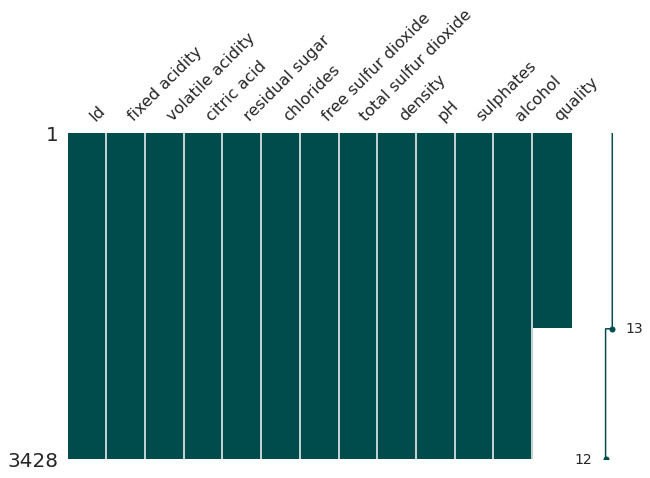

In [12]:
# 一応欠損値の有無を可視化します
# Search for missing data

msno.matrix(df=all_data, figsize=(10,6), color=(0,.3,.3))

欠損値はありません<br>
No missing value

In [13]:
all_data.drop(columns=['Id']).describe().T\
        .style.bar(subset=['mean'], color=px.colors.qualitative.G10[0])\
        .background_gradient(subset=['std'], cmap='Greens')\
        .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3428.000000,8.366949,1.688977,4.900000,7.100000,7.900000,9.100000,15.900000
volatile acidity,3428.000000,0.526284,0.174668,0.120000,0.390000,0.510000,0.640000,1.580000
citric acid,3428.000000,0.267264,0.187249,0.000000,0.100000,0.260000,0.420000,0.760000
residual sugar,3428.000000,2.405703,0.884205,1.200000,2.000000,2.200000,2.600000,14.000000
chlorides,3428.000000,0.081636,0.024901,0.012000,0.071000,0.079000,0.088000,0.467000
free sulfur dioxide,3428.000000,17.038652,9.994522,1.000000,8.000000,16.000000,24.000000,68.000000
total sulfur dioxide,3428.000000,49.177800,32.893515,7.000000,23.000000,44.000000,65.000000,289.000000
density,3428.000000,0.996717,0.001825,0.990070,0.995500,0.996680,0.997800,1.003690
pH,3428.000000,3.311231,0.141937,2.740000,3.210000,3.310000,3.390000,4.010000
sulphates,3428.000000,0.643693,0.136701,0.390000,0.550000,0.620000,0.720000,1.950000


In [14]:
feat_ary = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

### 日本語訳
### Japanese
<br>
fixed acidity : 酒石酸濃度<br>
volatile acidity : 揮発性酸度<br>
citric acid : クエン酸<br>
residual sugar : 残糖量<br>
chlorides : 塩化ナトリウム濃度<br>
free sulfur dioxide : 遊離亜硫酸濃度<br>
total sulfur dioxide : 総亜硫酸（酸化防止剤）<br>
density : 密度（濃さ）<br>
pH : ペーハー<br>
sulphates : 硫酸カリウム濃度<br>
alcohol アルコール度数: <br>
いずれもワインの成分などを表す数値です

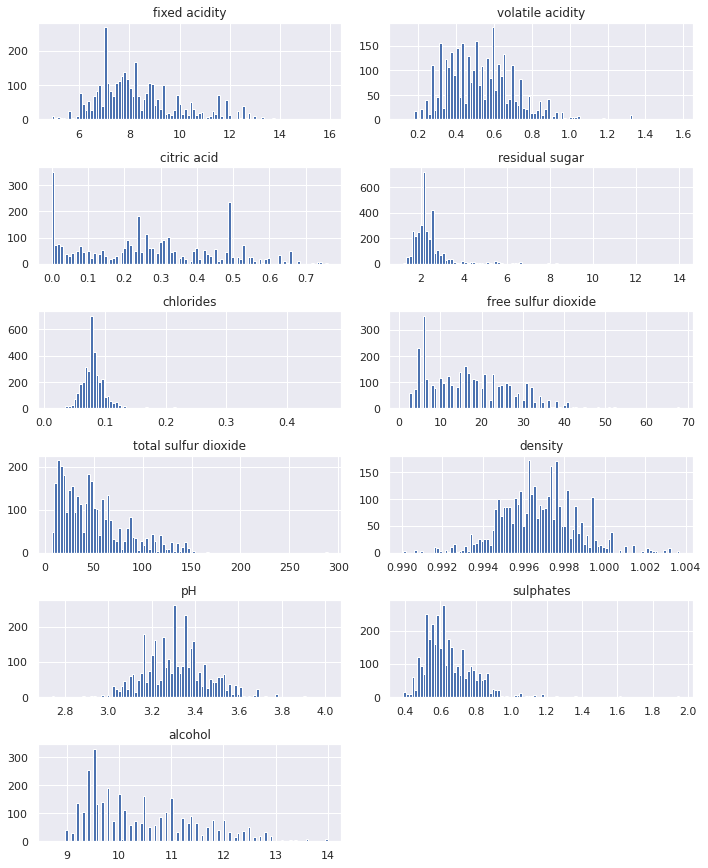

In [15]:
# 特徴量ごとの分布を可視化
# Visualization of distribution for each feature

figure = plt.figure(figsize=(10, 30))
count = 0
for i in range(len(feat_ary)):
    feat_name = feat_ary[i]
    plt.subplot(15, 2, count+1)
    plt.hist(all_data[feat_name], bins=100)
    plt.title(f'{feat_name}')
    count += 1
figure.tight_layout(h_pad=1.0, w_pad=0.8)
plt.show()

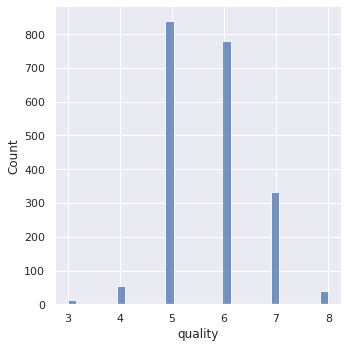

In [16]:
# qualityの分布を可視化
# Histogram of 'quality'

sns.displot(train['quality'], height=5)
plt.show()

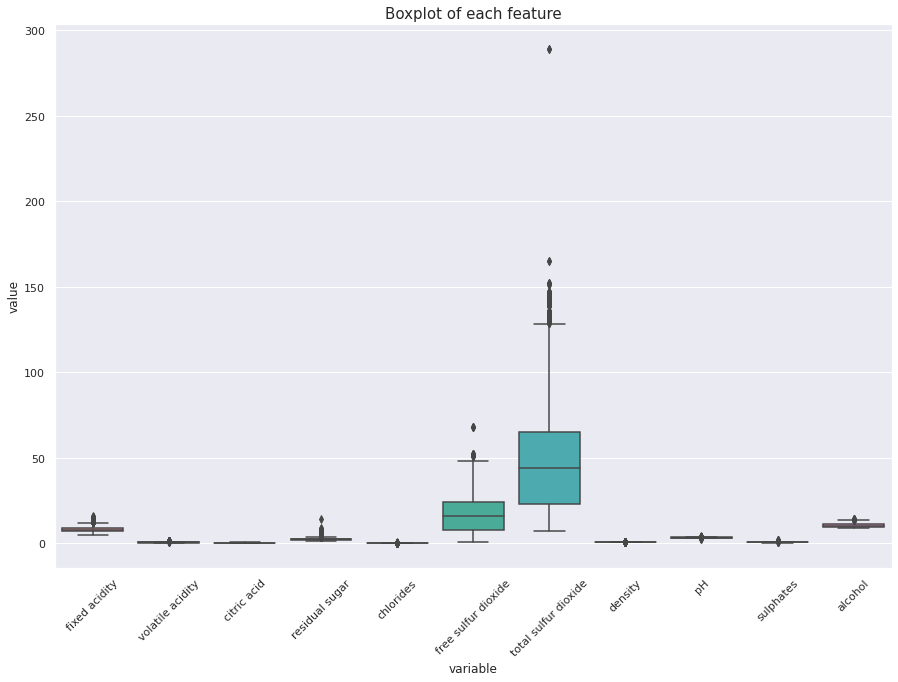

In [17]:
# Boxplot of each feature

df_all_data = pd.DataFrame(data = all_data, columns = feat_ary)
plt.figure(figsize=(15,10)) 
sns.boxplot(x="variable", y="value", data=pd.melt(df_all_data)).set_title('Boxplot of each feature',size=15)
plt.xticks(rotation=45)
plt.show()

In [18]:
# Split train and test

train = all_data.iloc[train.index[0]:train.index[-1]+1]
test = all_data.iloc[train.index[-1]+1:]

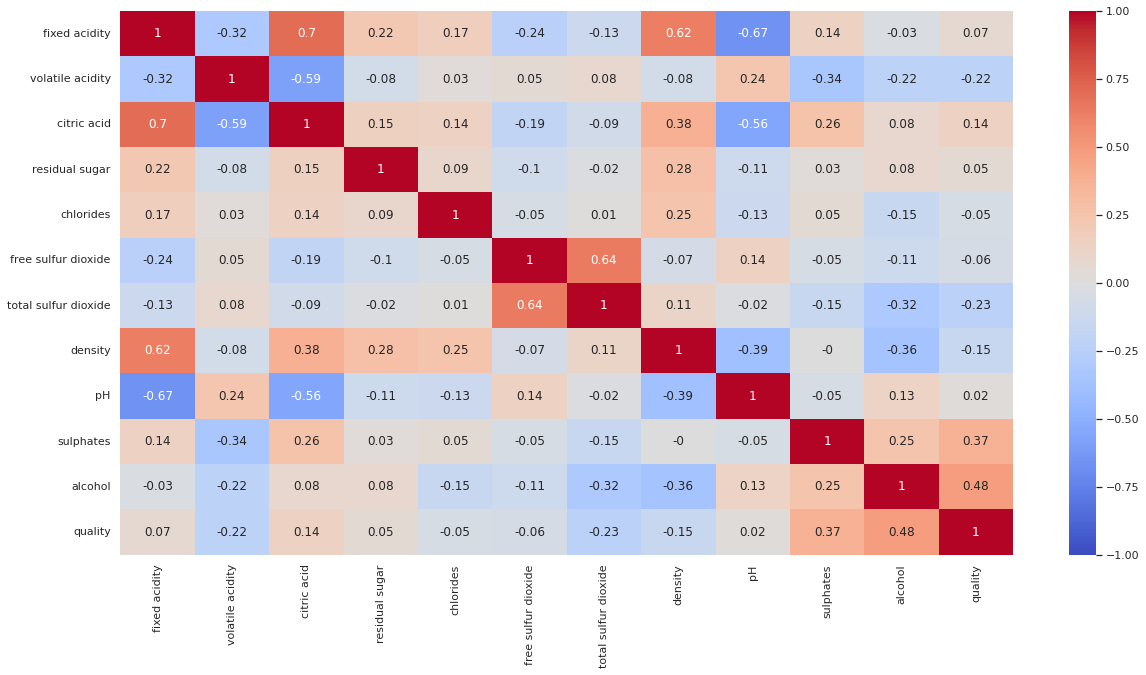

In [19]:
#Heatmap(train)

corr = train.drop(columns=['Id']).corr().round(2)
plt.figure(figsize=(20,10))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, square=False, annot=True, cmap='coolwarm')
plt.show()

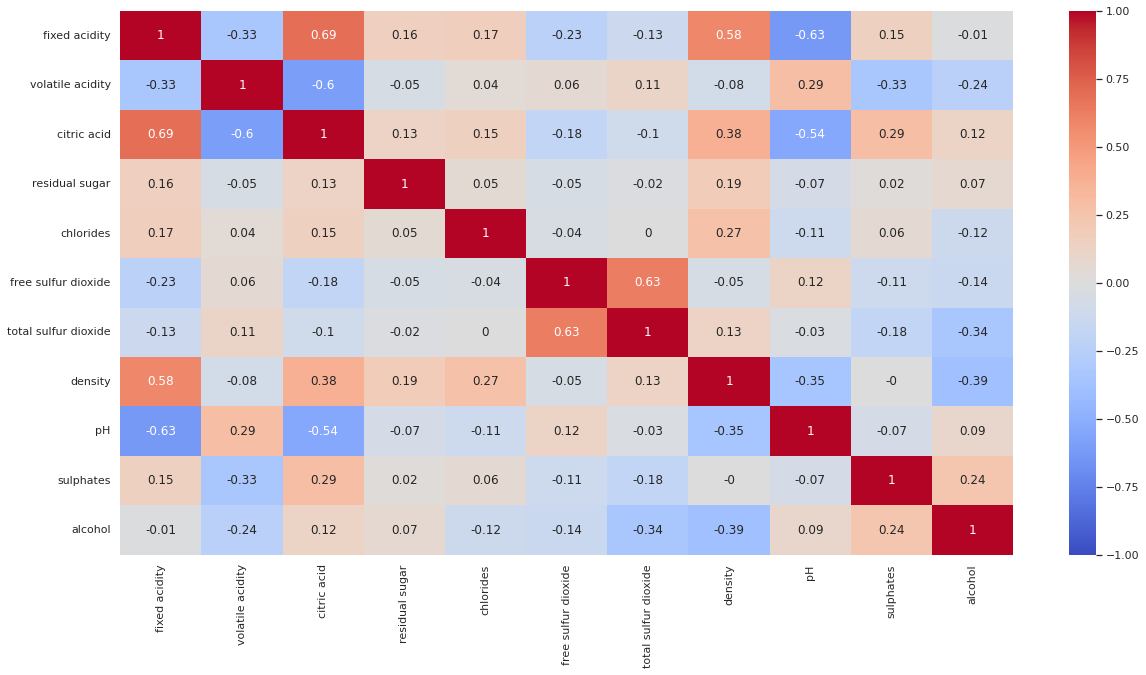

In [20]:
#Heatmap(test)

corr = test.drop(columns=['Id', 'quality']).corr().round(2)
plt.figure(figsize=(20,10))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, square=False, annot=True, cmap='coolwarm')
plt.show()

# 5. Modeling

In [21]:
X = train[feat_ary]
value = train['quality']

In [22]:
# optunaを使うか使わないかを指定
# optuna switch(Using optuna or not)
optuna_switch = 'off' # 'on' or other

# GPUを使うかどうかを指定（使うときはACCELERATORを指定する）
# usingGPU(Using GPU or not)
usingGPU = 'n' # 'y' or other

In [23]:
# params

objective = "multiclass"
metric = 'multi_logloss'
num_class = 9,
test_size = 0.2

In [24]:
# optuna

def tuneParam(X, value, test_size, usingGPU):
    if usingGPU == 'y':
        opt_params = {
            'device': 'gpu',
            "objective" : objective,
            "metric" : metric,
            "num_class" : num_class
        }
    else:
        opt_params = {
            "objective" : objective,
            "metric" : metric,
            "num_class" : num_class
        }

    X_train,X_test,y_train,y_test = train_test_split(
        X,
        value,
        test_size = test_size
    )

    reg_train = lgb.Dataset(
        X_train,
        y_train
    )

    reg_eval = lgb.Dataset(
        X_test,
        y_test,
        reference = reg_train
    )

    opt = lgbo.train(
        opt_params,
        reg_train,
        valid_sets = reg_eval,
        verbose_eval = False,
        num_boost_round = 100,
        early_stopping_rounds = 100
    )
    return opt

In [25]:
%%time

if optuna_switch == 'on':
    opt = tuneParam(X, value, test_size, usingGPU)
    print(opt.params)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


### MEMO
val_score: 0.935965<br>
'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': [9], 'feature_pre_filter': False, 'lambda_l1': 8.914203622960845e-05, 'lambda_l2': 0.004841743375102929, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.4477676682674993, 'bagging_freq': 2, 'min_child_samples': 5, 'num_iterations': 100, 'early_stopping_round': 100<br>
[8996]train's multi_logloss: 0.906151 valid's multi_logloss: 0.976567<br>
accuracy : 0.58010

In [26]:
%%time

# modeling

learning_rate = 0.0005 # 0.0001
num_iterations = 300000 # 100
max_depth = -1
min_data_in_leaf = 20

X_train, X_test, t_train, t_test = train_test_split(X, value, test_size=test_size, random_state=0)

lgb_train = lgb.Dataset(X_train, t_train)
lgb_eval = lgb.Dataset(X_test, t_test, reference=lgb_train)

if usingGPU == 'y':
    device = 'gpu'
else:
    device = ''

if optuna_switch == 'on':
    params = {
        'device': device,
        'task': 'train',
        'objective': objective,
        'metric': metric,
        'num_class': num_class,
        'boosting_type': 'gbdt',
        'learning_rate': learning_rate,
        'num_iterations': num_iterations,
        'max_depth': max_depth,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_pre_filter': opt.params['feature_pre_filter'],
        'lambda_l1': opt.params['lambda_l1'],
        'lambda_l2': opt.params['lambda_l2'],
        'num_leaves': opt.params['num_leaves'],
        'feature_fraction': opt.params['feature_fraction'],
        'bagging_fraction': opt.params['bagging_fraction'],
        'bagging_freq': opt.params['bagging_freq'],
        'min_child_samples': opt.params['min_child_samples'],
        'verbosity': -1
    }
else:
    params = {
        'device': device,
        'task': 'train',
        'objective': objective,
        'metric': metric,
        'num_class': num_class,
        'boosting_type': 'gbdt',
        'learning_rate': learning_rate,
        'num_iterations': num_iterations,
        'max_depth': max_depth,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_pre_filter': False,
        'lambda_l1': 8.914203622960845e-05,
        'lambda_l2': 0.004841743375102929,
        'num_leaves':2,
        'feature_fraction': 0.4,
        'bagging_fraction': 0.4477676682674993,
        'bagging_freq': 2,
        'min_child_samples': 5,
        'verbosity': -1
    }

evaluation_results = {}                       # 学習の経過を保存する
model = lgb.train(
    params,
    valid_names=['train', 'valid'],           # 学習経過で表示する名称
    valid_sets=[lgb_train, lgb_eval],         # モデル検証のデータセット
    evals_result=evaluation_results,          # 学習の経過を保存
    train_set=lgb_train,
    early_stopping_rounds=1000,#100
    verbose_eval=1000
)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 1000 rounds
[1000]	train's multi_logloss: 1.1402	valid's multi_logloss: 1.1043
[2000]	train's multi_logloss: 1.08145	valid's multi_logloss: 1.05459
[3000]	train's multi_logloss: 1.04331	valid's multi_logloss: 1.02589
[4000]	train's multi_logloss: 1.01758	valid's multi_logloss: 1.00878
[5000]	train's multi_logloss: 0.998717	valid's multi_logloss: 0.998011
[6000]	train's multi_logloss: 0.983996	valid's multi_logloss: 0.991253
[7000]	train's multi_logloss: 0.972339	valid's multi_logloss: 0.986766
[8000]	train's multi_logloss: 0.962652	valid's multi_logloss: 0.98402
[9000]	train's multi_logloss: 0.954217	valid's multi_logloss: 0.981575
[10000]	train's multi_logloss: 0.946777	valid's multi_logloss: 0.979914
[11000]	train's multi_logloss: 0.940224	valid's multi_logloss: 0.978511
[12000]	train's multi_logloss: 0.934294	vali

# 6. Learning result

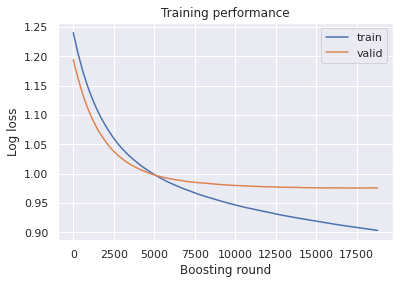

In [27]:
# 学習過程を可視化
plt.plot(evaluation_results['train']['multi_logloss'], label='train')
plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
plt.ylabel('Log loss')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

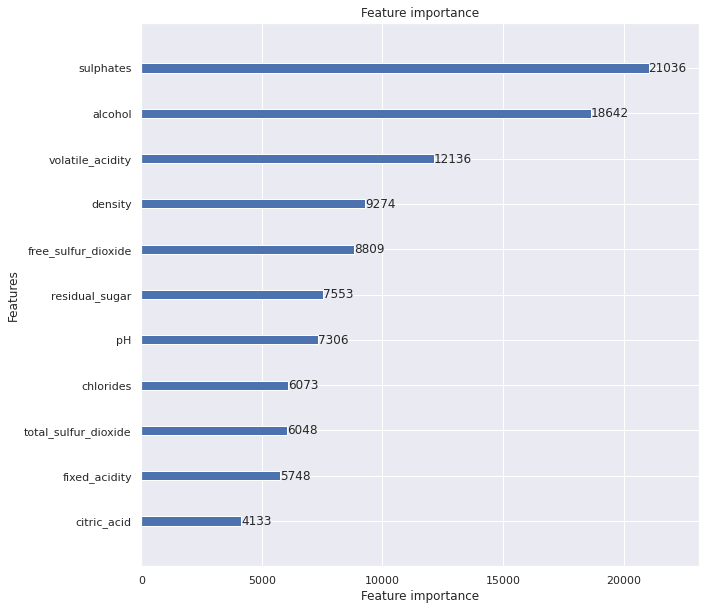

In [28]:
# Feature importance

fig, ax = plt.subplots(figsize=(10, 10))
lgb.plot_importance(model, ax=ax)

In [29]:
pred = model.predict(X_test, num_iteration=model.best_iteration)
pred

array([[9.82570686e-16, 9.82570686e-16, 9.82570686e-16, ...,
        6.65069173e-01, 1.45603571e-01, 1.52474080e-02],
       [6.57246234e-16, 6.57246234e-16, 6.57246234e-16, ...,
        1.75351992e-01, 2.23474441e-02, 1.73485701e-03],
       [8.15863861e-16, 8.15863861e-16, 8.15863861e-16, ...,
        4.56875400e-01, 4.26377728e-01, 4.20801117e-02],
       ...,
       [1.19001931e-15, 1.19001931e-15, 1.19001931e-15, ...,
        6.17862528e-01, 1.46403193e-01, 1.40931782e-02],
       [1.17578236e-15, 1.17578236e-15, 1.17578236e-15, ...,
        5.87979694e-01, 1.23069983e-01, 3.42520809e-03],
       [1.17830715e-15, 1.17830715e-15, 1.17830715e-15, ...,
        4.28971826e-01, 6.74961890e-02, 6.03771341e-03]])

In [30]:
pred_max = np.argmax(pred, axis=1) # 一番大きいもの
pred_max

array([6, 5, 6, 5, 6, 5, 5, 5, 6, 6, 6, 5, 6, 5, 5, 5, 5, 6, 7, 6, 7, 5,
       6, 5, 5, 5, 6, 6, 7, 6, 6, 5, 6, 6, 5, 6, 6, 6, 6, 5, 7, 5, 5, 5,
       6, 6, 6, 6, 6, 5, 6, 5, 5, 6, 5, 6, 6, 5, 5, 6, 6, 7, 6, 5, 6, 5,
       5, 5, 5, 6, 6, 6, 5, 5, 6, 5, 5, 6, 5, 7, 5, 5, 6, 6, 6, 7, 5, 6,
       6, 5, 6, 6, 5, 6, 6, 5, 6, 6, 5, 5, 5, 5, 5, 6, 5, 5, 6, 6, 6, 6,
       5, 5, 7, 6, 5, 5, 6, 7, 5, 5, 5, 5, 7, 5, 7, 7, 6, 7, 5, 5, 7, 5,
       6, 7, 5, 7, 6, 6, 5, 5, 6, 6, 6, 5, 6, 7, 6, 6, 7, 6, 7, 5, 6, 5,
       5, 6, 5, 6, 6, 7, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 7, 6, 5, 6,
       5, 6, 6, 6, 6, 5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 6, 5, 6, 6, 7, 5, 5,
       5, 6, 6, 7, 6, 6, 5, 6, 5, 7, 5, 5, 5, 5, 6, 6, 5, 6, 5, 6, 6, 5,
       6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 5, 6, 5, 5, 5, 5, 6, 6, 5, 6, 5, 7,
       5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 5, 5, 5, 5, 5, 7, 7, 5, 6, 5, 6, 6,
       7, 7, 5, 6, 6, 6, 6, 6, 6, 5, 6, 6, 5, 6, 6, 6, 5, 6, 5, 6, 5, 5,
       6, 5, 6, 6, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 6,

In [31]:
print('min: {}'.format(pred_max.min()))
print('max: {}'.format(pred_max.max()))

min: 5
max: 7


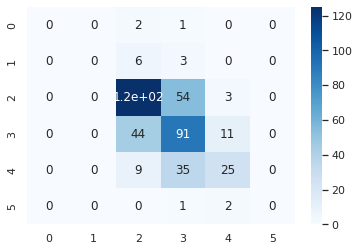

In [32]:
cm = confusion_matrix(t_test, pred_max)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.show()

In [33]:
classReport = classification_report(t_test, pred_max)
print(classReport)

score = accuracy_score(t_test, pred_max)
print('accuracy :', '{:.5f}'.format(score))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00      0.00         9
         5.0       0.67      0.69      0.68       182
         6.0       0.49      0.62      0.55       146
         7.0       0.61      0.36      0.45        69
         8.0       0.00      0.00      0.00         3

    accuracy                           0.58       412
   macro avg       0.30      0.28      0.28       412
weighted avg       0.57      0.58      0.57       412

accuracy : 0.58495


# 7. Prediction

In [34]:
%%time

result = model.predict(test[feat_ary])
result

CPU times: user 17.1 s, sys: 10.2 ms, total: 17.1 s
Wall time: 4.44 s


array([[9.08566747e-16, 9.08566747e-16, 9.08566747e-16, ...,
        4.72159686e-01, 3.78054301e-02, 1.24139553e-03],
       [1.19486325e-15, 1.19486325e-15, 1.19486325e-15, ...,
        5.44041672e-01, 1.76900217e-01, 8.22818953e-03],
       [1.08248829e-15, 1.08248829e-15, 1.08248829e-15, ...,
        4.89378462e-01, 5.11436764e-02, 3.42157353e-03],
       ...,
       [6.77262718e-16, 6.77262718e-16, 6.77262718e-16, ...,
        2.26705946e-01, 2.01639481e-02, 1.46697573e-03],
       [7.22135783e-16, 7.22135783e-16, 7.22135783e-16, ...,
        1.41104471e-01, 2.73626632e-02, 3.08496207e-03],
       [1.21219682e-15, 1.21219682e-15, 1.21219682e-15, ...,
        3.17419000e-01, 9.37960897e-02, 6.50856604e-03]])

In [35]:
result_max = np.argmax(result, axis=1) # 一番大きいもの
result_max

array([6, 6, 6, ..., 5, 5, 5])

# 8. Make submission file

In [36]:
sample_submission['quality'] = result_max
sample_submission

,Id,quality
0,2056,6
1,2057,6
2,2058,6
3,2059,6
4,2060,6
...,...,...
1367,3423,5
1368,3424,6
1369,3425,5
1370,3426,5


In [37]:
sample_submission['quality'].unique()

array([6, 5, 7, 4])

In [38]:
sample_submission.to_csv('submission.csv', index=False)